# **N-STEP SARSA CODE**

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import deque, defaultdict
#from linearApprox import *
import itertools


#  **UTILITY CODE**

In [ ]:
def jains_index(edrs):
    """Compute Jain's Fairness Index."""
    if all(edr == 0 for edr in edrs.values()):
        return 0.0
    numerator = sum(edrs.values())**2
    denominator = len(edrs) * sum(v**2 for v in edrs.values())
    return numerator / denominator if denominator > 0 else 0.0

def featurize_state(state, goal_order):
    ent_state, edrs = state
    edge_features = [age / 10.0 if age >= 0 else -1.0 for _, age in ent_state]
    edr_features = list(edrs)
    return np.array(edge_features + edr_features, dtype=np.float32)

class LinearQApproximator:
    def __init__(self, feature_size):
        self.weights = {}  # Dict[action_key] = weight_vector
        self.feature_size = feature_size

    def _action_key(self, action):
        consumed_paths, goal_list = action

        # Handle the no-op case: goal_list is None for no-op action
        if goal_list is None:
            return ((), None)  # Ensure this is hashable for no-op action

        # Sort paths and goals for consistency in hashing
        sorted_paths = tuple(sorted(tuple(sorted(path)) for path in consumed_paths))
        sorted_goals = tuple(sorted(goal_list))
        return (sorted_paths, sorted_goals)

    def _init_weights(self, action_key):
        if action_key not in self.weights:
            self.weights[action_key] = np.zeros(self.feature_size)

    def get_q_value(self, features, action):
        key = self._action_key(action)
        self._init_weights(key)
        return float(np.dot(self.weights[key], features))

    def update(self, features, action, target, alpha):
        key = self._action_key(action)
        self._init_weights(key)
        prediction = np.dot(self.weights[key], features)
        error = target - prediction
        self.weights[key] += alpha * error * features


def get_possible_multi_actions(state, goalEdges):
    actions = []
    existing_edges = {edge for edge, age in state if age >= 0}

    def find_path(start, end, path=None):
        if path is None:
            path = []
        if start == end:
            return [path]
        paths = []
        for edge in existing_edges:
            if edge not in path:
                if edge[0] == start:
                    new_paths = find_path(edge[1], end, path + [edge])
                    paths.extend(new_paths)
                elif edge[1] == start:
                    new_paths = find_path(edge[0], end, path + [edge])
                    paths.extend(new_paths)
        return paths

    # Single-goal actions
    single_goal_actions = []
    for goal in goalEdges:
        start, end = goal
        paths = find_path(start, end)
        for path in paths:
            if len(path) > 0:
                single_goal_actions.append((path, goal))
                actions.append(([path], [goal]))  # wrapped in list for multi-path format

    # Multi-goal actions (disjoint paths only)
    for k in range(2, len(single_goal_actions) + 1):
        for combo in itertools.combinations(single_goal_actions, k):
            paths, goals = zip(*combo)
            flat_edges = [e for path in paths for e in path]
            if len(flat_edges) == len(set(flat_edges)):
                actions.append((list(paths), list(goals)))

    # Add no-op action explicitly
    actions.append(([], None))  # no-op action

    return actions

def compute_reward(action, goal_success_queues, pSwap, mode="basic", alpha=1.0, epsilon=1e-3, noop_penalty=0.0):
    consumed_edges, goals = action
    if not goals or not consumed_edges:
        return -noop_penalty, False

    total_reward = 0.0
    any_success = False
    used_edges = set()

    for goal, path in zip(goals, consumed_edges):
        path_edges = set(path)
        if not path_edges.isdisjoint(used_edges):
            continue
        used_edges.update(path_edges)

        success_prob = pSwap ** (len(path) - 1)
        edr = sum(goal_success_queues[goal]) / len(goal_success_queues[goal]) + epsilon
        x = success_prob / edr
        success = (random.random() < success_prob)
        any_success = any_success or success

        if mode == "partial":
            base = math.log(1 + x)
            total_reward += base if success else 0.5 * base
        else:
            total_reward += math.log(1 + x) if success else 0.0

    return total_reward, any_success

def performAction(action, aaugmented_state):
    consumed_paths, goal_edges = action
    ent_state, edr_bins = augmented_state
    new_state = list(ent_state)
    for path in consumed_paths:
        for edge_to_consume in path:
            for i, (edge, age) in enumerate(new_state):
                if edge == edge_to_consume:
                    new_state[i] = (edge, -1)
                    break
    return (tuple(new_state), edr_bins)


# **SIMULATION CODE**

In [ ]:
def simulate_policy(
    Q_table,
    edges,
    goal_edges,
    p_swap,
    p_gen,
    max_age,
    num_steps,
    edr_window_size=100,
    burn_in=None,
    plot=True
):
    if burn_in is None:
        burn_in = num_steps // 2

    raw = [(e, -1) for e in edges]
    current = get_augmented_state(raw, {g:0.0 for g in goal_edges}, goal_order=goal_edges)

    recent = {g: [] for g in goal_edges}
    edr_hist, jain_hist, tp_hist = {g:[] for g in goal_edges}, [], []
    valids, acts, qvals = [], [], []

    for t in range(num_steps):
        ent_state, _ = current
        acts_all = get_possible_multi_actions(ent_state, goal_edges)
        if ([], None) not in acts_all:
            acts_all.append(([], None))
        real = [a for a in acts_all if a != ([], None)]
        avail = len(real) > 0
        valids.append(1 if avail else 0)

        feats = featurize_state(current, goal_edges)
        best_a, best_q = max(((a, Q_table.get_q_value(feats, a)) for a in acts_all), key=lambda x: x[1])
        qvals.append(best_q)
        acts.append(1.0 if (avail and best_a in real) else 0.0)

        nxt = performAction(best_a, current)
        nxt = ageEntanglements(nxt, max_age)
        nxt = generateEntanglement(nxt, p_gen)

        consumed_paths, goals = best_a
        if goals is not None:
            for g, path in zip(goals, consumed_paths):
                if path:
                    succ = random.random() < (p_swap ** (len(path) - 1))
                    recent[g].append(1 if succ else 0)
                else:
                    recent[g].append(0)
            for g in goal_edges:
                if g not in goals:
                    recent[g].append(0)
        else:
            for g in goal_edges:
                recent[g].append(0)

        if len(recent[g]) > edr_window_size:
            recent[g].pop(0)

        edrs = {g: sum(recent[g]) / len(recent[g]) for g in goal_edges}
        for g in goal_edges:
            edr_hist[g].append(edrs[g])

        total = sum(edrs.values())
        tp_hist.append(total)
        jain_hist.append(jains_index(edrs))

        current = get_augmented_state(nxt[0], edrs, goal_order=goal_edges)

    if plot:
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle(
            f"Policy Sim — pSwap={p_swap}, pGen={p_gen}, maxAge={max_age}, steps={num_steps}, window={edr_window_size}",
            fontsize=14
        )

        # (0) EDR + Jain
        ax0 = axs[0]
        for g in goal_edges:
            ax0.plot(edr_hist[g], label=f"EDR {g}")
        ax0.plot(jain_hist, '--', label="Jain's", linewidth=2)
        ax0.set_title("EDR (solid) & Jain (dashed)")
        ax0.set_xlabel("Timestep")
        ax0.set_ylabel("Value")
        ax0.set_ylim(0, 1.05)
        ax0.legend()

        # (1) single Pareto point after burn-in
        ax1 = axs[1]
        avg_tp = np.mean(tp_hist[burn_in:])
        avg_jain = np.mean(jain_hist[burn_in:])
        ax1.scatter([avg_tp], [avg_jain], s=100, c='crimson')
        ax1.set_title("Final Pareto Point")
        ax1.set_xlabel("Avg Throughput")
        ax1.set_ylabel("Avg Jain")
        ax1.set_xlim(0, max(tp_hist) * 1.1)
        ax1.set_ylim(0, 1.05)
        ax1.text(avg_tp, avg_jain, f"  ({avg_tp:.3f}, {avg_jain:.3f})")

        # (2) best Q-value
        ax2 = axs[2]
        ax2.plot(qvals, color='slateblue')
        ax2.set_title("Best Q-Value Over Time")
        ax2.set_xlabel("Timestep")
        ax2.set_ylabel("Q-Value")

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    burn_in_idx = 5000
    final_edrs = {g: np.mean(edr_hist[g][burn_in_idx:]) for g in goal_edges}
    final_tp = sum(final_edrs.values())
    final_jain = jains_index(final_edrs)

    print("\nMetrics After Burn-in (first 5000 steps ignored):")
    print("Mean EDRs:", {g: f"{v:.4f}" for g, v in final_edrs.items()})
    print(f"Total Throughput (sum of EDRs): {final_tp:.4f}")
    print(f"Jain's Fairness Index: {final_jain:.4f}")

    return {
        "edr_history": edr_hist,
        "jain_history": jain_hist,
        "throughput_history": tp_hist,
        "q_values": qvals
    }


In [6]:
def multi_simulate_policy(
    Q_table,
    edges,
    goal_edges,
    p_swap,
    p_gen,
    max_age,
    num_steps,
    edr_window_size=100,
    burn_in=None,
    seeds=[10, 20, 30, 40, 50],
    plot=True
):
    if burn_in is None:
        burn_in = num_steps // 2

    all_edrs = {g: [] for g in goal_edges}
    all_jains = []
    all_tp = []

    edr_time_series = {g: [] for g in goal_edges}
    jain_time_series = []

    goal_colors = {
        goal_edges[0]: "tab:blue",
        goal_edges[1]: "tab:green"
    }

    for seed in seeds:
        random.seed(seed)
        np.random.seed(seed)

        result = simulate_policy(
            Q_table=Q_table,
            edges=edges,
            goal_edges=goal_edges,
            p_swap=p_swap,
            p_gen=p_gen,
            max_age=max_age,
            num_steps=num_steps,
            edr_window_size=edr_window_size,
            burn_in=burn_in,
            plot=False  # Suppress individual plots
        )

        # Final metrics
        edr_hist = result["edr_history"]
        jain_hist = result["jain_history"]
        tp_hist = result["throughput_history"]

        for g in goal_edges:
            edr_time_series[g].append(edr_hist[g])
        jain_time_series.append(jain_hist)

        burn_in_idx = 5000
        edrs_final = {g: np.mean(edr_hist[g][burn_in_idx:]) for g in goal_edges}
        tp_final = sum(edrs_final.values())
        jain_final = jains_index(edrs_final)

        for g in goal_edges:
            all_edrs[g].append(edrs_final[g])
        all_tp.append(tp_final)
        all_jains.append(jain_final)

    if plot:
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle(
            f"Multi-Sim — {len(seeds)} Seeds | pSwap={p_swap}, pGen={p_gen}, maxAge={max_age}, steps={num_steps}",
            fontsize=14
        )

        # --- EDR time series ---
        ax0 = axs[0]
        for g in goal_edges:
            for run_edr in edr_time_series[g]:
                ax0.plot(run_edr, color=goal_colors[g], alpha=0.3)
            ax0.plot(np.mean(edr_time_series[g], axis=0), color=goal_colors[g], linewidth=2, label=f"EDR {g}")
        ax0.set_title("EDRs Over Time")
        ax0.set_xlabel("Timestep")
        ax0.set_ylabel("EDR")
        ax0.set_ylim(0, 1.05)
        ax0.legend()

        # --- Jain's Index time series ---
        ax1 = axs[1]
        for run_jain in jain_time_series:
            ax1.plot(run_jain, color="gray", alpha=0.3)
        ax1.plot(np.mean(jain_time_series, axis=0), color="black", linewidth=2, label="Jain’s Index")
        ax1.set_title("Jain's Index Over Time")
        ax1.set_xlabel("Timestep")
        ax1.set_ylabel("Jain's Fairness")
        ax1.set_ylim(0, 1.05)
        ax1.legend()

        # --- Pareto scatter plot ---
        ax2 = axs[2]
        ax2.scatter(all_tp, all_jains, c='crimson', s=60, label="Runs")
        ax2.scatter(np.mean(all_tp), np.mean(all_jains), c='black', s=100, marker='x', label="Mean")
        ax2.set_title("Pareto Points Across Seeds")
        ax2.set_xlabel("Avg Throughput")
        ax2.set_ylabel("Avg Jain")
        ax2.set_xlim(0, max(all_tp) * 1.1)
        ax2.set_ylim(0, 1.05)
        for tp, jn in zip(all_tp, all_jains):
            ax2.text(tp + 0.002, jn, f"({tp:.2f}, {jn:.2f})", fontsize=8)
        ax2.legend()

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    return {
        "avg_edrs": {g: np.mean(all_edrs[g]) for g in goal_edges},
        "avg_tp": np.mean(all_tp),
        "avg_jain": np.mean(all_jains),
        "edrs_by_seed": all_edrs,
        "tp_by_seed": all_tp,
        "jain_by_seed": all_jains
    }


#  **Q-LEARNING CODE** 

In [14]:
def run_q_learning_linear_policy(
    initialEdges, goalEdges, totalSteps,
    gamma, alpha, pGen, pSwap, maxAge,
    edr_window_size=100, reward_mode="basic", reward_epsilon=1e-3,
    noop_penalty=0.01, log_interval=10000,
    softmax=True, temperature=1.0, temperature_decay=0.9999,
    epsilon=0.01
):
    q_value_diffs = []
    q_value_diffs_per_goal = {g: [] for g in goalEdges}

    goal_success_queues = {
        g: deque([1] * (edr_window_size // 2) + [0] * (edr_window_size // 2), maxlen=edr_window_size)
        for g in goalEdges
    }

    raw = [(e, -1) for e in initialEdges]
    edr_snap = {g: 0.0 for g in goalEdges}
    current = (tuple(raw), tuple(edr_snap[g] for g in goalEdges))

    Q = LinearQApproximator(feature_size=len(initialEdges) + len(goalEdges))
    temperature_curr = temperature

    edr_tracking_steps = []
    edr_tracking_history = {g: [] for g in goalEdges}

    def select_action(state, temperature):
        feats = featurize_state(state, goalEdges)
        acts = get_possible_multi_actions(state[0], goalEdges)
        if ([], None) not in acts:
            acts.append(([], None))

        if softmax:
            q_vals = np.array([Q.get_q_value(feats, a) for a in acts], dtype=np.float64)
            scaled_qs = q_vals / max(temperature, 1e-6)
            exp_qs = np.exp(scaled_qs - np.max(scaled_qs))
            probs = exp_qs / np.sum(exp_qs)
            chosen = acts[np.random.choice(len(acts), p=probs)]
        else:
            if random.random() < epsilon:
                chosen = random.choice(acts)
            else:
                chosen = max(acts, key=lambda a: Q.get_q_value(feats, a))

        return chosen

    state = current

    for t in range(totalSteps):
        temperature_curr = max(0.01, temperature_curr * temperature_decay)

        action = select_action(state, temperature_curr)
        next_state = performAction(action, state)
        next_state = ageEntanglements(next_state, maxAge)
        next_state = generateEntanglement(next_state, pGen)

        r, succ = compute_reward(
            action, goal_success_queues, pSwap,
            mode=reward_mode, epsilon=reward_epsilon, noop_penalty=noop_penalty
        )

        consumed_edges, goal_list = action
        successful_goals = set(goal_list) if succ else set()
        for gh in goalEdges:
            goal_success_queues[gh].append(1 if gh in successful_goals else 0)

        edr_snap = {g: sum(goal_success_queues[g]) / len(goal_success_queues[g]) for g in goalEdges}
        augmented_next_state = (next_state[0], tuple(edr_snap[g] for g in goalEdges))

        if t % log_interval == 0:
            edr_tracking_steps.append(t)
            for g in goalEdges:
                edr_tracking_history[g].append(edr_snap[g])

        feats = featurize_state(state, goalEdges)
        feats_next = featurize_state(augmented_next_state, goalEdges)
        next_actions = get_possible_multi_actions(augmented_next_state[0], goalEdges)
        max_q_next = max([Q.get_q_value(feats_next, a) for a in next_actions], default=0.0)

        target = r + gamma * max_q_next
        current_q = Q.get_q_value(feats, action)
        diff = abs(current_q - target)
        q_value_diffs.append(diff)

        for g in goalEdges:
            if action[1] is not None and g in action[1]:
                q_value_diffs_per_goal[g].append(diff)
            else:
                q_value_diffs_per_goal[g].append(np.nan)

        Q.update(feats, action, target, alpha)
        state = augmented_next_state

    return Q, q_value_diffs, q_value_diffs_per_goal, edr_tracking_steps, edr_tracking_history

def train_q_learning_linear_policy(
    edges, goal_edges, p_swap, p_gen, max_age,
    seed, totalSteps, alpha, gamma,
    edr_window_size, reward_mode, reward_epsilon,
    noop_penalty, log_interval,
    softmax, temperature, temperature_decay,
    epsilon
):
    random.seed(seed)
    np.random.seed(seed)

    result = run_q_learning_linear_policy(
        initialEdges=edges,
        goalEdges=goal_edges,
        totalSteps=totalSteps,
        gamma=gamma,
        alpha=alpha,
        pGen=p_gen,
        pSwap=p_swap,
        maxAge=max_age,
        edr_window_size=edr_window_size,
        reward_mode=reward_mode,
        reward_epsilon=reward_epsilon,
        noop_penalty=noop_penalty,
        log_interval=log_interval,
        softmax=softmax,
        temperature=temperature,
        temperature_decay=temperature_decay,
        epsilon=epsilon
    )

    if result is None:
        print("Error: Q-learning returned None.")
        return

    Q, q_diffs, q_diffs_per_goal, edr_steps, edr_hist = result

    # Plot Q-value convergence
    plt.figure(figsize=(10, 4))
    plt.plot(q_diffs)
    plt.xlabel("Q-learning Updates")
    plt.ylabel("Q-value Difference")
    plt.title("Q-value Convergence (Global)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot EDR evolution
    plt.figure(figsize=(10, 5))
    for g in goal_edges:
        plt.plot(edr_steps, edr_hist[g], label=f"EDR {g}")
    plt.xlabel("Training Step")
    plt.ylabel("EDR Estimate")
    plt.title("EDR Evolution During Training")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return Q


#  **SARSA CODE**

In [ ]:
def run_n_step_sarsa_linear_multi(
    initialEdges, goalEdges, totalSteps, nLookahead,
    gamma, alpha, pGen, pSwap, maxAge,
    edr_window_size=100, reward_mode="basic", reward_epsilon=1e-3,
    noop_penalty=0.01, log_interval=10000,
    initial_temperature=1.0, temperature_decay=0.9999
):
    q_value_diffs = []
    q_value_diffs_per_goal = {g: [] for g in goalEdges}

    goal_success_queues = {
        g: deque([1] * (edr_window_size // 2) + [0] * (edr_window_size // 2), maxlen=edr_window_size)
        for g in goalEdges
    }

    raw = [(e, -1) for e in initialEdges]
    edr_snap = {g: 0.0 for g in goalEdges}
    current = (tuple(raw), tuple(edr_snap[g] for g in goalEdges))

    state_buffer = deque([current])
    reward_buffer = deque()
    Q = LinearQApproximator(feature_size=len(initialEdges) + len(goalEdges))
    temperature = initial_temperature

    edr_tracking_steps = []
    edr_tracking_history = {g: [] for g in goalEdges}

    action_counter = {
        'noop': 0,
        'goal1': 0,
        'goal2': 0,
        'both': 0
    }

    def select_action(state, temperature):
        feats = featurize_state(state, goalEdges)
        acts = get_possible_multi_actions(state[0], goalEdges)
        
        # Debug: Print all possible actions and their Q-values
        # print("Possible actions and Q-values:")
        # for action in acts:
        #     action_q_value = Q.get_q_value(feats, action)
        #     print(f"Action: {action}, Q-value: {action_q_value}")

        # Ensure the no-op action is included
        if ([], None) not in acts:
            acts.append(([], None))

        # Calculate Q-values and probabilities using softmax
        q_values = np.array([Q.get_q_value(feats, a) for a in acts], dtype=np.float64)
        scaled_qs = q_values / max(temperature, 1e-6)
        exp_qs = np.exp(scaled_qs - np.max(scaled_qs))
        probs = exp_qs / np.sum(exp_qs)
        
        # Sample action based on the probabilities
        idx = np.random.choice(len(acts), p=probs)
        chosen = acts[idx]

        # Debug: Print the chosen action
        # print(f"Chosen action: {chosen}")

        # Track the action type for frequency analysis
        if chosen == ([], None):
            action_counter['noop'] += 1
        elif len(chosen[1]) == 1:
            if chosen[1][0] == goalEdges[0]:
                action_counter['goal1'] += 1
            else:
                action_counter['goal2'] += 1
        elif len(chosen[1]) == 2:
            action_counter['both'] += 1

        return chosen


    action_buffer = deque([select_action(current, temperature)])

    for t in range(totalSteps):
        if t % 1_000_000:
            print(f"Timestep {t}")
        temperature = max(0.01, temperature * temperature_decay)

        S_t = state_buffer[-1]
        A_t = action_buffer[-1]

        ns = performAction(A_t, S_t)
        ns = ageEntanglements(ns, maxAge)
        ns = generateEntanglement(ns, pGen)

        r, succ = compute_reward(
            A_t, goal_success_queues, pSwap,
            mode=reward_mode, epsilon=reward_epsilon, noop_penalty=noop_penalty
        )

        consumed_edges, goal_list = A_t
        successful_goals = set(goal_list) if succ else set()
        for gh in goalEdges:
            goal_success_queues[gh].append(1 if gh in successful_goals else 0)

        reward_buffer.append(r)

        edr_snap = {g: sum(goal_success_queues[g]) / len(goal_success_queues[g]) for g in goalEdges}
        next_state = (ns[0], tuple(edr_snap[g] for g in goalEdges))

        if t % log_interval == 0:
            edr_tracking_steps.append(t)
            for g in goalEdges:
                edr_tracking_history[g].append(edr_snap[g])

        A_next = select_action(next_state, temperature)

        state_buffer.append(next_state)
        action_buffer.append(A_next)

        if len(reward_buffer) >= nLookahead:
            G = sum((gamma**i) * reward_buffer[i] for i in range(nLookahead))
            s_n = state_buffer[nLookahead]
            a_n = action_buffer[nLookahead]
            feats_n = featurize_state(s_n, goalEdges)
            G += (gamma**nLookahead) * Q.get_q_value(feats_n, a_n)

            s_tau = state_buffer[0]
            a_tau = action_buffer[0]
            feats_tau = featurize_state(s_tau, goalEdges)
            old_q = Q.get_q_value(feats_tau, a_tau)
            diff = abs(G - old_q)
            q_value_diffs.append(diff)

            for gg in goalEdges:
                if a_tau[1] is not None and gg in a_tau[1]:
                    q_value_diffs_per_goal[gg].append(diff)
                else:
                    q_value_diffs_per_goal[gg].append(float('nan'))

            Q.update(feats_tau, a_tau, G, alpha)

            state_buffer.popleft()
            action_buffer.popleft()
            reward_buffer.popleft()

    while reward_buffer:
        n = len(reward_buffer)
        G = sum((gamma**i) * reward_buffer[i] for i in range(n))
        if n < len(state_buffer):
            s_n = state_buffer[n]
            a_n = action_buffer[n]
            feats_n = featurize_state(s_n, goalEdges)
            G += (gamma**n) * Q.get_q_value(feats_n, a_n)

        s_tau = state_buffer[0]
        a_tau = action_buffer[0]
        feats_tau = featurize_state(s_tau, goalEdges)
        old_q = Q.get_q_value(feats_tau, a_tau)
        diff = abs(G - old_q)
        q_value_diffs.append(diff)

        for gg in goalEdges:
            if a_tau[1] is not None and gg in a_tau[1]:
                q_value_diffs_per_goal[gg].append(diff)
            else:
                q_value_diffs_per_goal[gg].append(float('nan'))

        Q.update(feats_tau, a_tau, G, alpha)

        state_buffer.popleft()
        action_buffer.popleft()
        reward_buffer.popleft()

    return Q, q_value_diffs, q_value_diffs_per_goal, edr_tracking_steps, edr_tracking_history, action_counter

######################################################################################################################################################

def train_sarsa_linear_policy(
    edges, goal_edges, p_swap, p_gen, max_age,
    seed,
    totalSteps, nLookahead,
    alpha, gamma,
    edr_window_size, reward_mode, reward_epsilon,
    noop_penalty, log_interval,
    initial_temperature, temperature_decay
):
    random.seed(seed)
    np.random.seed(seed)

    # Run the SARSA multi-step learning
    result = run_n_step_sarsa_linear_multi(
        initialEdges=edges,
        goalEdges=goal_edges,
        totalSteps=totalSteps,
        nLookahead=nLookahead,
        gamma=gamma,
        alpha=alpha,
        pGen=p_gen,
        pSwap=p_swap,
        maxAge=max_age,
        edr_window_size=edr_window_size,
        reward_mode=reward_mode,
        reward_epsilon=reward_epsilon,
        noop_penalty=noop_penalty,
        log_interval=log_interval,
        initial_temperature=initial_temperature,
        temperature_decay=temperature_decay
    )

    # Check if result is valid
    if result is None:
        print("Error: run_n_step_sarsa_linear_multi returned None.")
        return

    # Unpack results
    Q, q_diffs, q_diffs_per_goal, edr_steps, edr_hist, action_counter = result

    # --- Q-value convergence ---
    plt.figure(figsize=(10, 4))
    plt.plot(q_diffs)
    plt.xlabel("SARSA Updates")
    plt.ylabel("Q-value Difference")
    plt.title("Q-value Convergence (Global)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- EDR evolution ---
    plt.figure(figsize=(10, 5))
    for g in goal_edges:
        plt.plot(edr_steps, edr_hist[g], label=f"EDR {g}")
    plt.xlabel("Training Step")
    plt.ylabel("EDR Estimate")
    plt.title("EDR Evolution During Training")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Action frequency plot ---
    labels = ['No-op', 'Goal 1', 'Goal 2', 'Both Goals']
    frequencies = [
        action_counter['noop'],
        action_counter['goal1'],
        action_counter['goal2'],
        action_counter['both']
    ]
    frequencies = [f / totalSteps for f in frequencies]

    plt.figure(figsize=(8, 6))
    plt.bar(labels, frequencies, color=['gray', 'blue', 'green', 'orange'])
    plt.xlabel("Action Type")
    plt.ylabel("Proportion of Total Actions")
    plt.title("Proportion of Each Action Type Chosen During Training")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    return Q


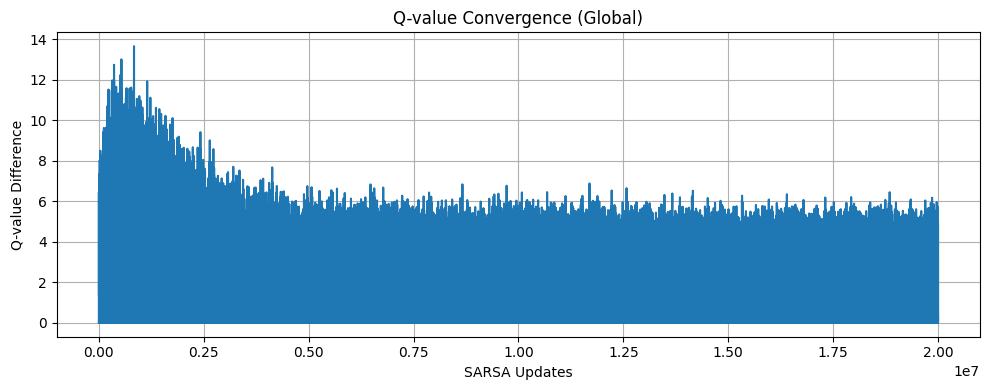

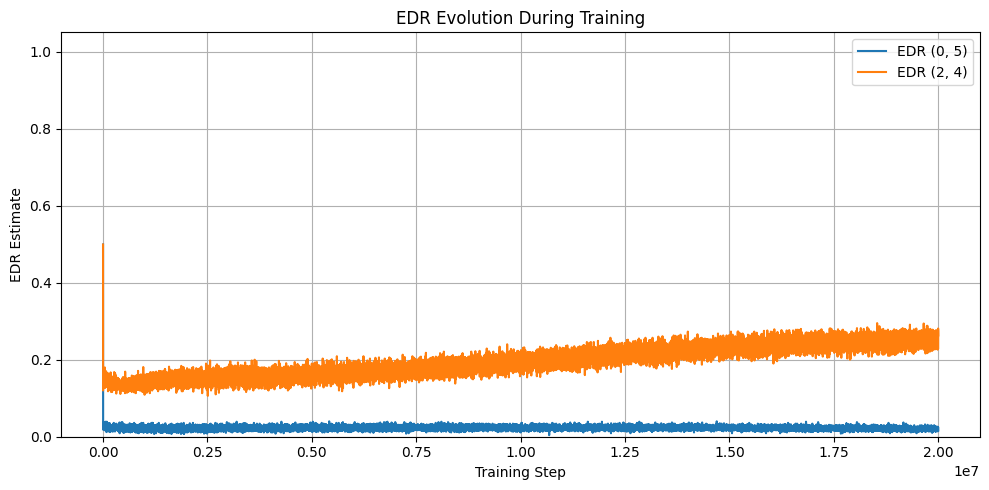

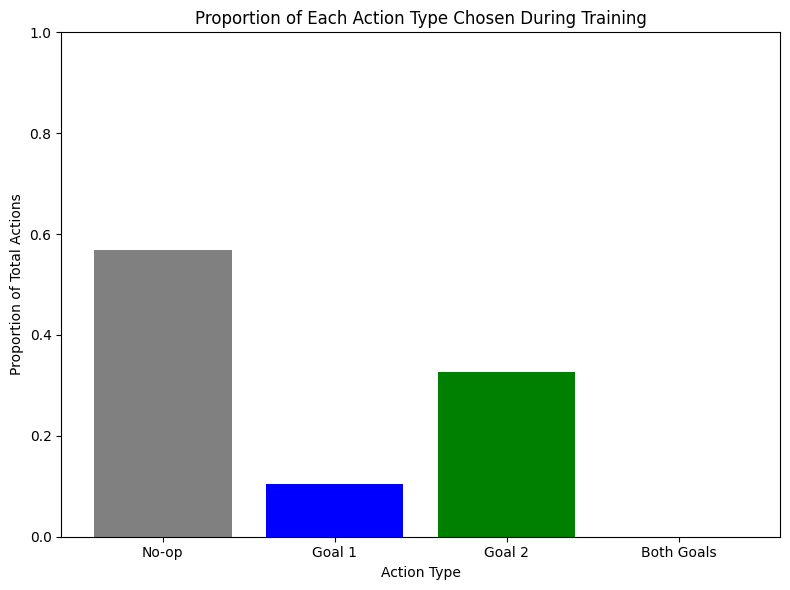

done training


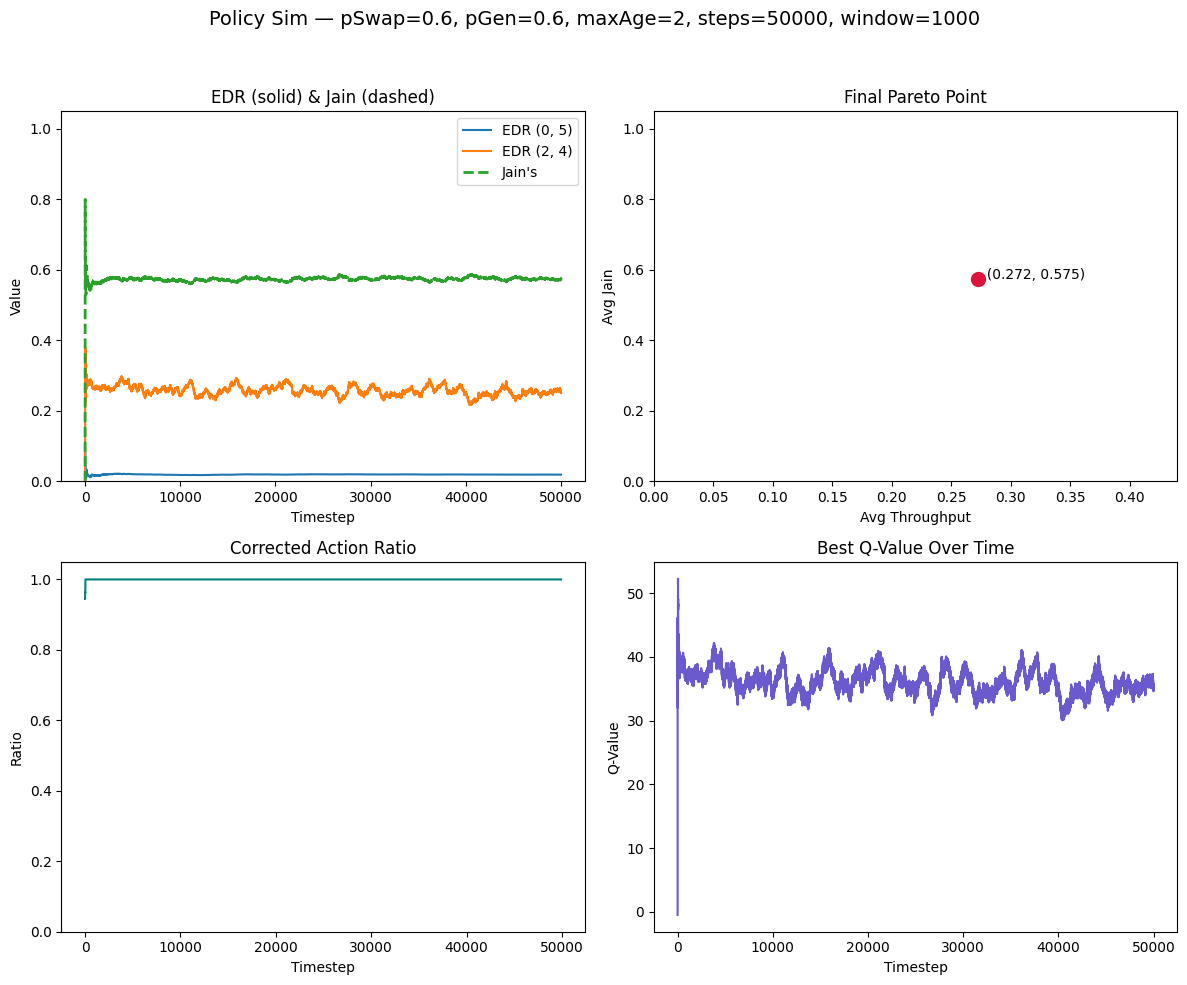


Metrics After Burn-in (first 10,000 steps ignored):
Mean EDRs: {(0, 5): '0.0190', (2, 4): '0.2554'}
Total Throughput (sum of EDRs): 0.2744
Jain's Fairness Index: 0.5739

Metrics After Burn-in (first 10,000 steps ignored):
Mean EDRs: {(0, 5): '0.0175', (2, 4): '0.2565'}
Total Throughput (sum of EDRs): 0.2741
Jain's Fairness Index: 0.5681

Metrics After Burn-in (first 10,000 steps ignored):
Mean EDRs: {(0, 5): '0.0169', (2, 4): '0.2514'}
Total Throughput (sum of EDRs): 0.2683
Jain's Fairness Index: 0.5670

Metrics After Burn-in (first 10,000 steps ignored):
Mean EDRs: {(0, 5): '0.0173', (2, 4): '0.2523'}
Total Throughput (sum of EDRs): 0.2696
Jain's Fairness Index: 0.5682

Metrics After Burn-in (first 10,000 steps ignored):
Mean EDRs: {(0, 5): '0.0168', (2, 4): '0.2532'}
Total Throughput (sum of EDRs): 0.2700
Jain's Fairness Index: 0.5661

Metrics After Burn-in (first 10,000 steps ignored):
Mean EDRs: {(0, 5): '0.0162', (2, 4): '0.2541'}
Total Throughput (sum of EDRs): 0.2704
Jain's Fai

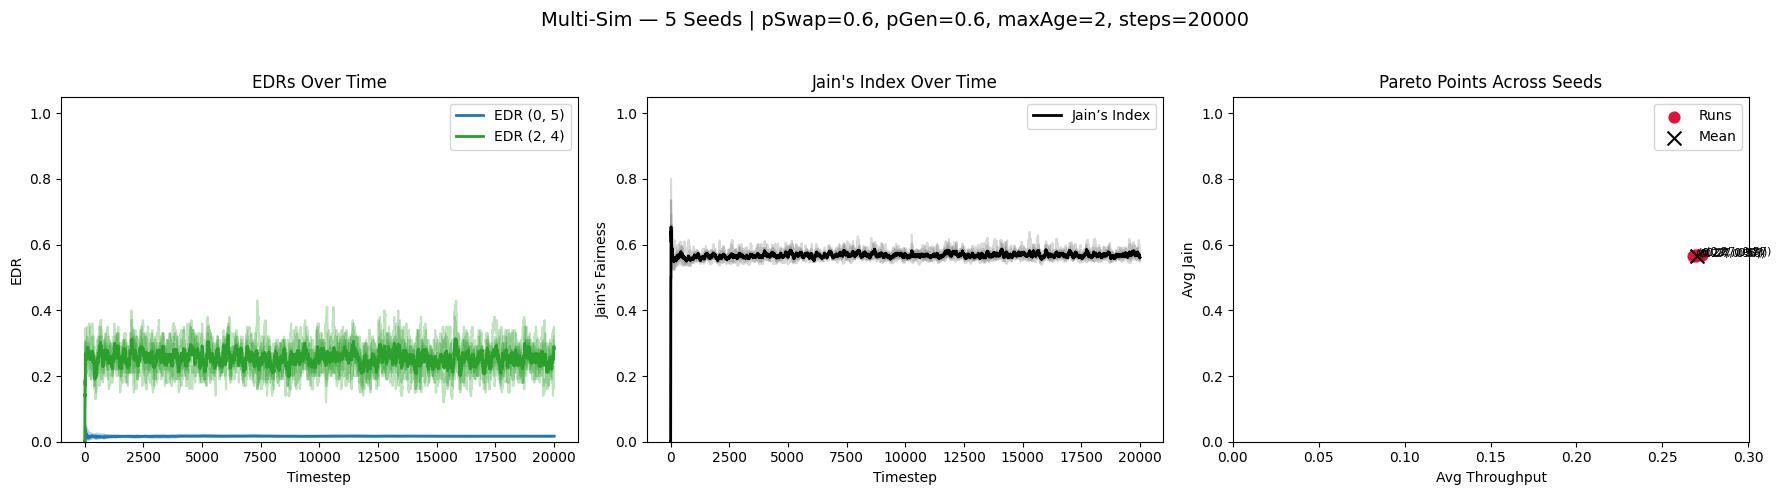

{'avg_edrs': {(0, 5): np.float64(0.01696308271640596),
  (2, 4): np.float64(0.2531062666666667)},
 'avg_tp': np.float64(0.2700693493830727),
 'avg_jain': np.float64(0.566712516206677),
 'edrs_by_seed': {(0, 5): [np.float64(0.017760711025665652),
   np.float64(0.01707209868057527),
   np.float64(0.017336141612180753),
   np.float64(0.016301482719884915),
   np.float64(0.01634497954372322)],
  (2, 4): [np.float64(0.25545),
   np.float64(0.25183733333333336),
   np.float64(0.25358533333333333),
   np.float64(0.25330600000000003),
   np.float64(0.25135266666666667)]},
 'tp_by_seed': [np.float64(0.2732107110256657),
  np.float64(0.2689094320139086),
  np.float64(0.2709214749455141),
  np.float64(0.26960748271988494),
  np.float64(0.2676976462103899)],
 'jain_by_seed': [np.float64(0.5691926730810829),
  np.float64(0.5674800767917033),
  np.float64(0.5680461095960291),
  np.float64(0.5640894716926672),
  np.float64(0.5647542498719021)]}

In [ ]:
edges       = [(0,1), (1,3), (2,3), (3,4), (4,5)]
goal_edges  = [(0,5), (2,4)]
pSwap       = 0.6
pGen        = 0.6
maxAge      = 2


maxAge      = 2
totalSteps     = 100_000_000
nLookahead     = 3
gamma          = 0.99
alpha          = 0.01
windowSize     = 1000
reward_mode    = 'basic'
reward_epsilon = 1e-3

# Softmax temperature parameters
initial_temperature = 5.0
final_temperature   = 0.1
temperature_decay   = (final_temperature / initial_temperature) ** (1.0 / (totalSteps * 0.9))

# Seed
seed = 30
random.seed(seed)
np.random.seed(seed)

# --- Train N-step SARSA policy (with temperature-based softmax) ---
Q1 = train_sarsa_linear_policy(
    edges=edges,
    goal_edges=goal_edges,
    p_swap=pSwap,
    p_gen=pGen,
    max_age=maxAge,
    seed=seed,
    totalSteps=totalSteps,
    nLookahead=nLookahead,
    alpha=alpha,
    gamma=gamma,
    edr_window_size=windowSize,
    reward_mode=reward_mode,
    reward_epsilon=reward_epsilon,
    noop_penalty=0.0,
    log_interval=1000,
    initial_temperature=initial_temperature,
    temperature_decay=temperature_decay
)
print('done training')
# --- Evaluate learned policy ---
simulate_policy(
    Q_table=Q1,
    edges=edges,
    goal_edges=goal_edges,
    p_swap=pSwap,
    p_gen=pGen,
    max_age=maxAge,
    num_steps=50_000,
    edr_window_size=windowSize,
    plot=True
)
seed = 10
random.seed(seed)
np.random.seed(seed)

multi_simulate_policy(
    Q_table=Q1,
    edges=edges,
    goal_edges=goal_edges,
    p_swap=pSwap,
    p_gen=pGen,
    max_age=maxAge,
    num_steps=20_000,
    seeds=[10, 20, 30, 40, 50]
)



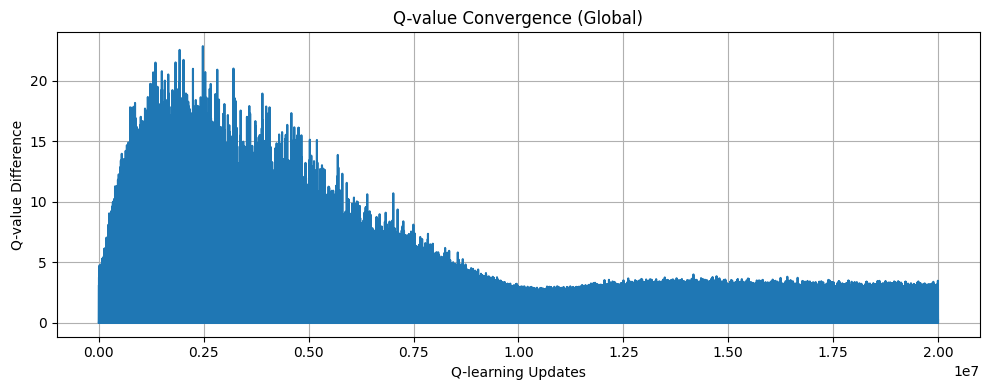

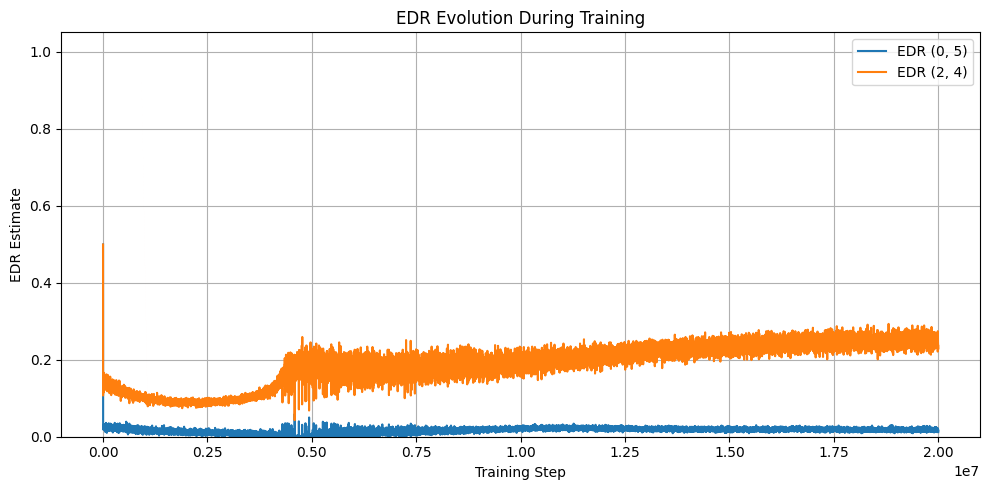

Done training Q-learning policy


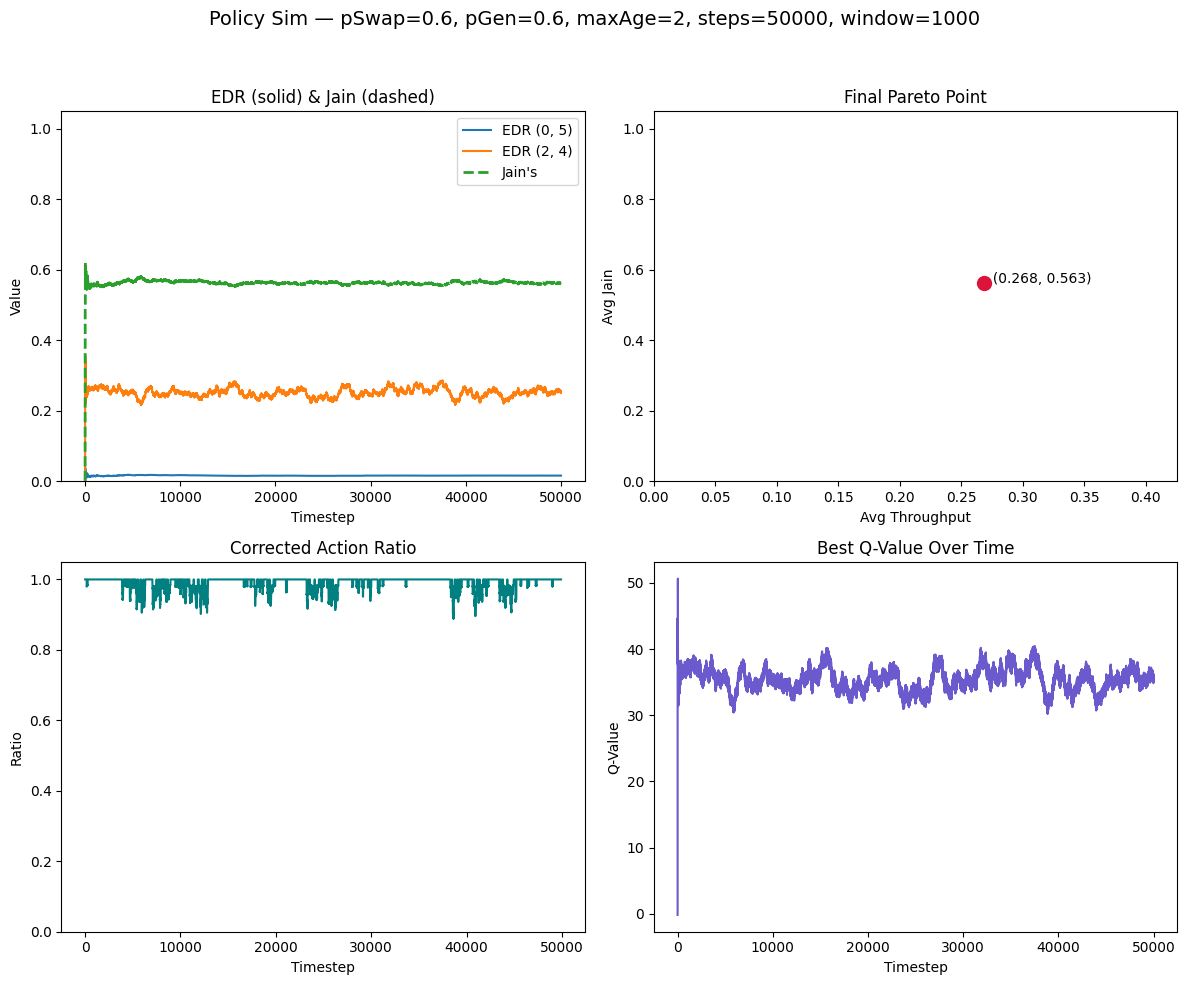


Metrics After Burn-in (first 10,000 steps ignored):
Mean EDRs: {(0, 5): '0.0158', (2, 4): '0.2513'}
Total Throughput (sum of EDRs): 0.2672
Jain's Fairness Index: 0.5628

Metrics After Burn-in (first 10,000 steps ignored):
Mean EDRs: {(0, 5): '0.0180', (2, 4): '0.2538'}
Total Throughput (sum of EDRs): 0.2718
Jain's Fairness Index: 0.5707

Metrics After Burn-in (first 10,000 steps ignored):
Mean EDRs: {(0, 5): '0.0169', (2, 4): '0.2526'}
Total Throughput (sum of EDRs): 0.2696
Jain's Fairness Index: 0.5667

Metrics After Burn-in (first 10,000 steps ignored):
Mean EDRs: {(0, 5): '0.0177', (2, 4): '0.2470'}
Total Throughput (sum of EDRs): 0.2647
Jain's Fairness Index: 0.5711

Metrics After Burn-in (first 10,000 steps ignored):
Mean EDRs: {(0, 5): '0.0177', (2, 4): '0.2524'}
Total Throughput (sum of EDRs): 0.2700
Jain's Fairness Index: 0.5696

Metrics After Burn-in (first 10,000 steps ignored):
Mean EDRs: {(0, 5): '0.0168', (2, 4): '0.2467'}
Total Throughput (sum of EDRs): 0.2635
Jain's Fai

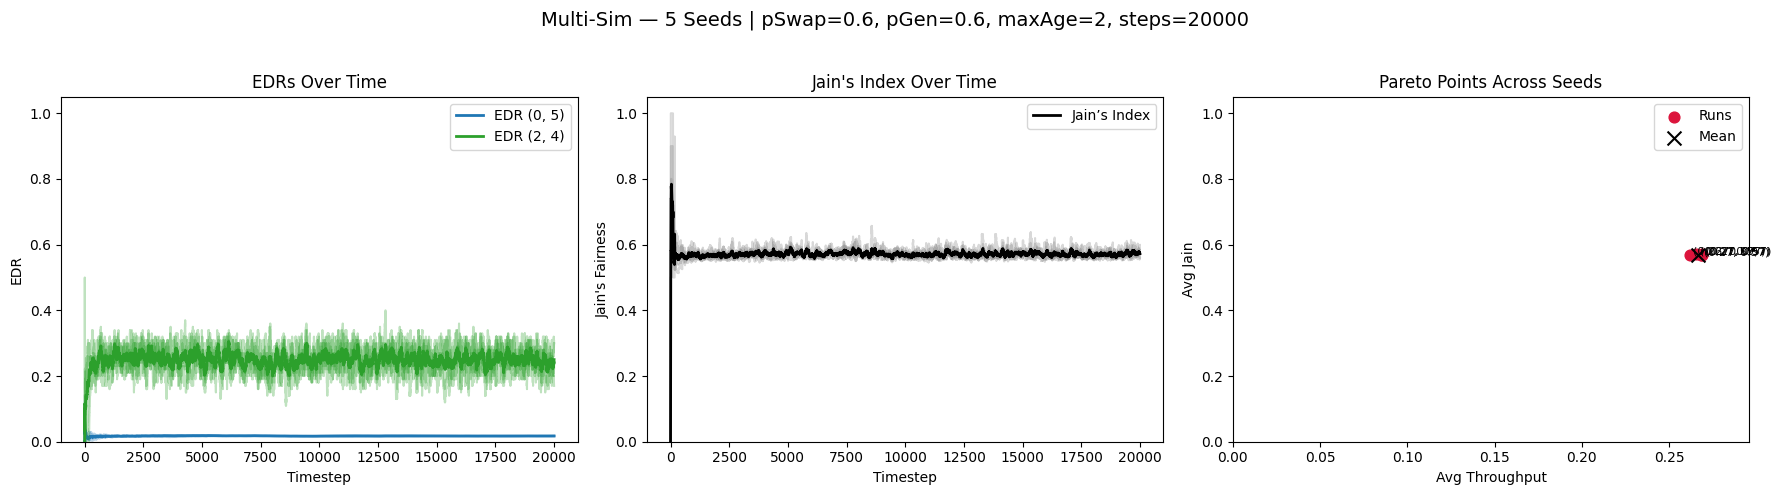

{'avg_edrs': {(0, 5): np.float64(0.017497953505920837),
  (2, 4): np.float64(0.24929680000000004)},
 'avg_tp': np.float64(0.26679475350592086),
 'avg_jain': np.float64(0.5698472519381628),
 'edrs_by_seed': {(0, 5): [np.float64(0.017895897174425742),
   np.float64(0.017208766382892343),
   np.float64(0.017760468422115348),
   np.float64(0.01751780316282686),
   np.float64(0.0171068323873439)],
  (2, 4): [np.float64(0.2508746666666667),
   np.float64(0.2511746666666667),
   np.float64(0.24797733333333333),
   np.float64(0.251562),
   np.float64(0.24489533333333335)]},
 'tp_by_seed': [np.float64(0.26877056384109244),
  np.float64(0.26838343304955903),
  np.float64(0.2657378017554487),
  np.float64(0.26907980316282687),
  np.float64(0.26200216572067725)],
 'jain_by_seed': [np.float64(0.5709728663707057),
  np.float64(0.5681930434730338),
  np.float64(0.5712558230462648),
  np.float64(0.5693000768909814),
  np.float64(0.5695144499098282)]}

In [ ]:
import math
import random
import numpy as np

# === Parameters ===
edges       = [(0,1), (1,3), (2,3), (3,4), (4,5)]
goal_edges  = [(0,5), (2,4)]
pSwap       = 0.6
pGen        = 0.6
maxAge      = 2

totalSteps     = 100_000_000
gamma          = 0.99
alpha          = 0.01
windowSize     = 1000
reward_mode    = 'basic'
reward_epsilon = 1e-3

initial_temperature = 5.0
final_temperature   = 0.1
temperature_decay   = (final_temperature / initial_temperature) ** (1.0 / (totalSteps * 0.9))

epsilon = 0.01  # Only used if softmax=False
softmax = True

# === Seed setup ===
seed = 30
random.seed(seed)
np.random.seed(seed)

# === Train Q-learning policy ===
Q_qlearning = train_q_learning_linear_policy(
    edges=edges,
    goal_edges=goal_edges,
    p_swap=pSwap,
    p_gen=pGen,
    max_age=maxAge,
    seed=seed,
    totalSteps=totalSteps,
    alpha=alpha,
    gamma=gamma,
    edr_window_size=windowSize,
    reward_mode=reward_mode,
    reward_epsilon=reward_epsilon,
    noop_penalty=0.0,
    log_interval=1000,
    softmax=softmax,
    temperature=initial_temperature,
    temperature_decay=temperature_decay,
    epsilon=epsilon
)
print("Done training Q-learning policy")

# === Evaluate learned Q-learning policy ===
simulate_policy(
    Q_table=Q_qlearning,
    edges=edges,
    goal_edges=goal_edges,
    p_swap=pSwap,
    p_gen=pGen,
    max_age=maxAge,
    num_steps=50_000,
    edr_window_size=windowSize,
    plot=True
)

# === Run multiple simulations with different seeds ===
multi_simulate_policy(
    Q_table=Q_qlearning,
    edges=edges,
    goal_edges=goal_edges,
    p_swap=pSwap,
    p_gen=pGen,
    max_age=maxAge,
    num_steps=20_000,
    seeds=[10, 20, 30, 40, 50]
)
